In [1]:
import  numpy as np
import math

import matplotlib.pyplot as plt
import matplotlib.axes as axes
%matplotlib inline
import networkx as nx

from qiskit import IBMQ,BasicAer
from qiskit.providers.ibmq import least_busy
from qiskit import QuantumCircuit,ClassicalRegister,QuantumRegister,execute

from qiskit.tools.visualization import plot_histogram

C:\Users\Voicu\AppData\Local\Continuum\anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


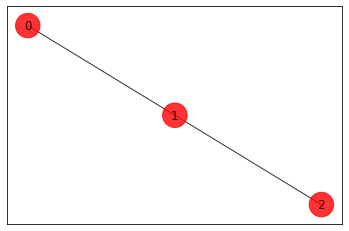

In [2]:
#Create the graph to be cut 

n=3 #nr nodes
G=nx.Graph()
G.add_nodes_from(np.arange(0,n,1))
elist=[(2,1,1.0),(1,0,1.0)]#list with conected  node and  coresponding weight(1,0,1.0)]
G.add_weighted_edges_from(elist)

colors=['r' for node in G.nodes()]
pos=nx.spring_layout(G)
default_axes=plt.axes(frameon=True)
nx.draw_networkx(G, node_color=colors,node_size=600,alpha=.8,ax=default_axes,pos=pos)


In [3]:
#compute the weight matrix

w=np.zeros([n,n])
for i in range (n):
    for j in range(n):
        temp=G.get_edge_data(i,j,default=0)
        if temp!=0:
            w[i,j]=temp['weight']
print(w)

[[0. 1. 0.]
 [1. 0. 1.]
 [0. 1. 0.]]


case=[0, 0, 0] cost= 0.0
case=[1, 0, 0] cost= 1.0
case=[0, 1, 0] cost= 2.0
case=[1, 1, 0] cost= 1.0
case=[0, 0, 1] cost= 1.0
case=[1, 0, 1] cost= 2.0
case=[0, 1, 1] cost= 1.0
case=[1, 1, 1] cost= 0.0

Best solution = [1, 0, 1] cost = 2.0


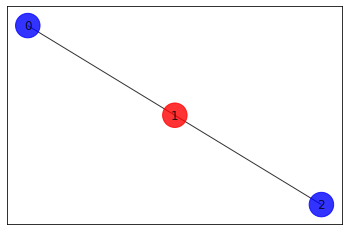

In [4]:
#brut force  for verification  :

best_cost_brute=0
for b in range(2**n):
    x=[int(t) for t in reversed(list(bin(b)[2:].zfill(n)))]
    cost=0
    for i in range(n):
        for j in range(n):
            cost=cost+w[i,j]*x[i]*(1-x[j])
            
    if best_cost_brute<=cost:
        best_cost_brute=cost
        xbest_brute=x
            
    print('case='+str(x)+' cost=',str(cost))
    
colors = ['r' if xbest_brute[i] == 0 else 'b' for i in range(n)]
nx.draw_networkx(G, node_color=colors, node_size=600, alpha=.8, pos=pos)
print('\nBest solution = ' + str(xbest_brute) + ' cost = ' + str(best_cost_brute))  

In [5]:
#compute Y,X 

sizeY=0
for i in range(n):
    sizeY=sizeY+i
    
sizeY=2**int(math.log(sizeY,2))*2  
print('sizeY='+str(sizeY))

sizeY=int(sizeY)
Y=np.zeros(sizeY)
print(Y)
y0=1
y=-2*y0

C=0
k=1
for i in range (n):
    for j in range (i):
        Y[k]=w[i,j]
        C=C+Y[k]*Y[k]*y*y
        k+=1
        #print(str(j)+' '+str(i)) #useful wey yo see conection betwen nodes for me 
        
C=math.sqrt(C)    
for i in range(sizeY):
    Y[i]=Y[i]*y/C

X=[1/math.sqrt(2**n) for i in range(2**n)]  

print(Y)
print(X)

sizeY=4
[0. 0. 0. 0.]
[-0.         -0.70710678 -0.         -0.70710678]
[0.35355339059327373, 0.35355339059327373, 0.35355339059327373, 0.35355339059327373, 0.35355339059327373, 0.35355339059327373, 0.35355339059327373, 0.35355339059327373]


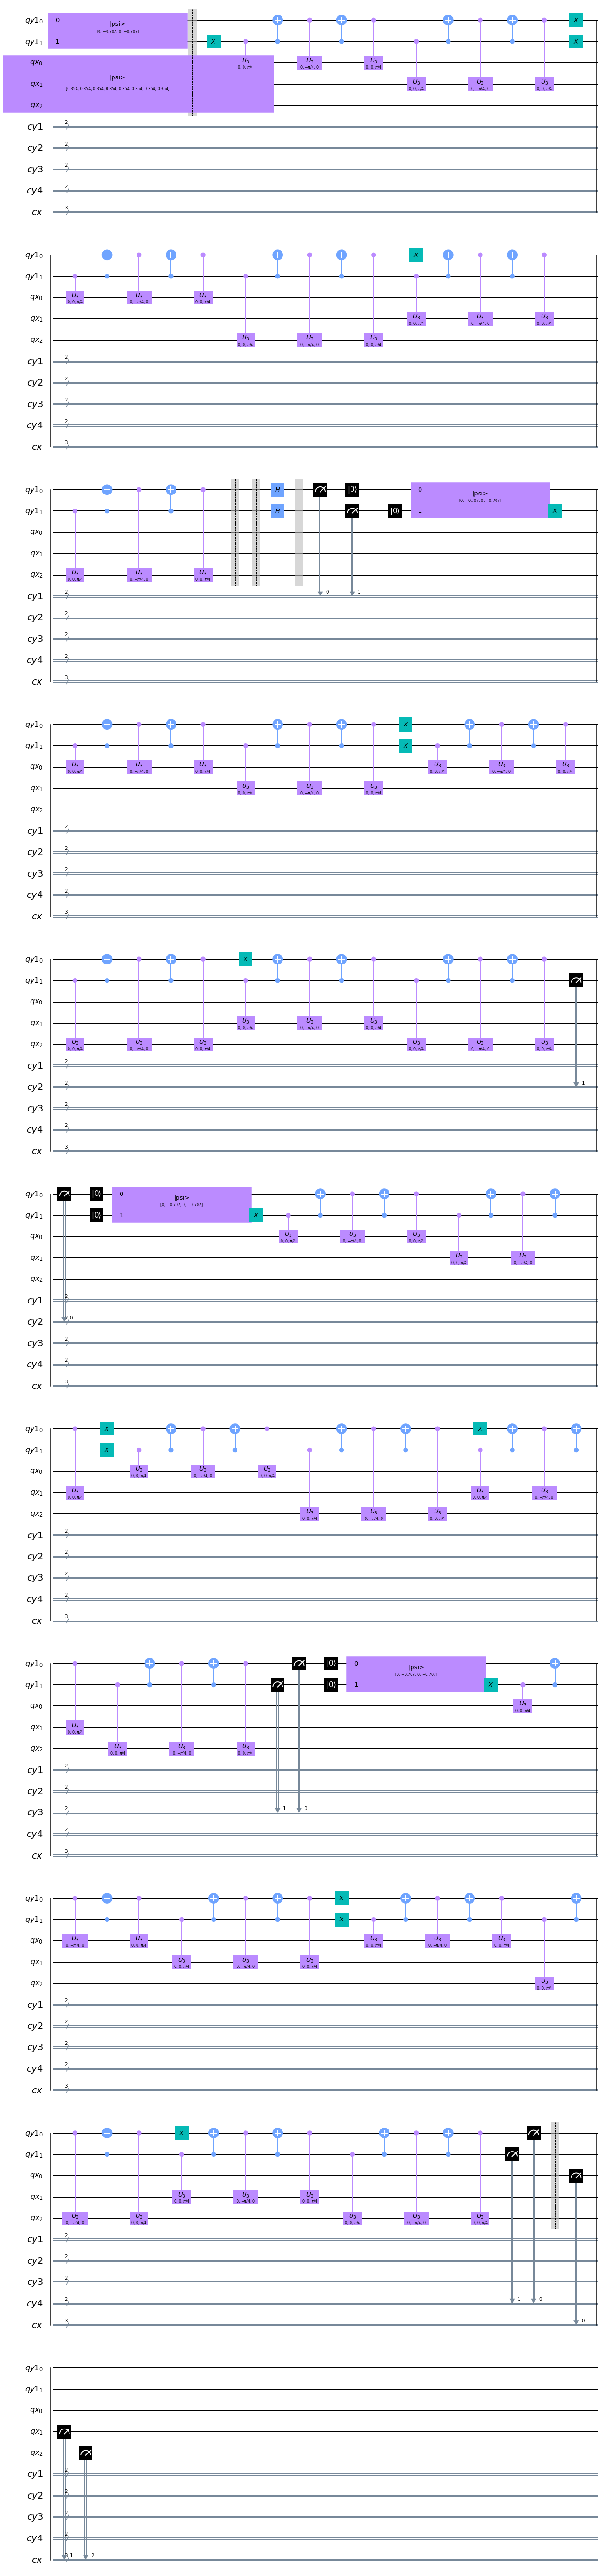

In [27]:
#build circuit for  these particular exmple  

def Gcirc3(n,m,stateVectorY,stateVectorX):
    
    qx=QuantumRegister(n,'qx')
    cx=ClassicalRegister(n,'cx')

    qy1=QuantumRegister(m,'qy1')
    cy1=ClassicalRegister(m,'cy1')
    cy2=ClassicalRegister(m,'cy2')
    cy3=ClassicalRegister(m,'cy3')
    cy4=ClassicalRegister(m,'cy4')
    qc=QuantumCircuit(qy1,qx,cy1,cy2,cy3,cy4,cx) 

    qc.initialize(stateVectorY,qy1)
    qc.initialize(stateVectorX,qx)

    qc.barrier()


    lam=np.pi/2 # because we want Z Pauli 

  

    #01
    qc.x(qy1[1]) #we need to have state 01 to aply Z matrices 
    qc.mcrz( lam, qy1, qx[0], use_basis_gates=False)
    qc.mcrz( lam, qy1, qx[1], use_basis_gates=False)
    qc.x(qy1[1]) #put qy[1] in his initial state 

    #02
    qc.x(qy1[0])
    qc.mcrz( lam, qy1, qx[0], use_basis_gates=False)
    qc.mcrz( lam, qy1, qx[2], use_basis_gates=False)
    qc.x(qy1[0])

    #12
    qc.mcrz( lam, qy1, qx[1], use_basis_gates=False)
    qc.mcrz( lam, qy1, qx[2], use_basis_gates=False)

    qc.barrier()



     
    qc.barrier()
    for i in range(m):
        qc.h(qy1[i])
     

    qc.barrier()
    
    for i in range(m):
        qc.measure(qy1[i], cy1[i])
        qc.reset(qy1[i])
    qc.initialize(stateVectorY,qy1)   
    #01
    qc.x(qy1[1]) #we need to have state 01 to aply Z matrices 
    qc.mcrz( lam, qy1, qx[0], use_basis_gates=False)
    qc.mcrz( lam, qy1, qx[1], use_basis_gates=False)
    qc.x(qy1[1]) #put qy[1] in his initial state 

    #02
    qc.x(qy1[0])
    qc.mcrz( lam, qy1, qx[0], use_basis_gates=False)
    qc.mcrz( lam, qy1, qx[2], use_basis_gates=False)
    qc.x(qy1[0])

    #12
    qc.mcrz( lam, qy1, qx[1], use_basis_gates=False)
    qc.mcrz( lam, qy1, qx[2], use_basis_gates=False)

    for i in range(m):
        qc.measure(qy1[i], cy2[i])
        qc.reset(qy1[i])
    qc.initialize(stateVectorY,qy1)   
    #01
    qc.x(qy1[1]) #we need to have state 01 to aply Z matrices 
    qc.mcrz( lam, qy1, qx[0], use_basis_gates=False)
    qc.mcrz( lam, qy1, qx[1], use_basis_gates=False)
    qc.x(qy1[1]) #put qy[1] in his initial state 

    #02
    qc.x(qy1[0])
    qc.mcrz( lam, qy1, qx[0], use_basis_gates=False)
    qc.mcrz( lam, qy1, qx[2], use_basis_gates=False)
    qc.x(qy1[0])

    #12
    qc.mcrz( lam, qy1, qx[1], use_basis_gates=False)
    qc.mcrz( lam, qy1, qx[2], use_basis_gates=False)

    for i in range(m):
        qc.measure(qy1[i], cy3[i])
        qc.reset(qy1[i])
    qc.initialize(stateVectorY,qy1)   
    #01
    qc.x(qy1[1]) #we need to have state 01 to aply Z matrices 
    qc.mcrz( lam, qy1, qx[0], use_basis_gates=False)
    qc.mcrz( lam, qy1, qx[1], use_basis_gates=False)
    qc.x(qy1[1]) #put qy[1] in his initial state 

    #02
    qc.x(qy1[0])
    qc.mcrz( lam, qy1, qx[0], use_basis_gates=False)
    qc.mcrz( lam, qy1, qx[2], use_basis_gates=False)
    qc.x(qy1[0])

    #12
    qc.mcrz( lam, qy1, qx[1], use_basis_gates=False)
    qc.mcrz( lam, qy1, qx[2], use_basis_gates=False)
  
    for i in range(m):
        qc.measure(qy1[i], cy4[i])
        
    qc.barrier()
    for i in range(n):
        qc.measure(qx[i], cx[i])
        
    qc.draw(output="mpl")
    return qc

qc=Gcirc3(3,2,Y,X)
qc.draw(output="mpl")

C:\Users\Voicu\AppData\Local\Continuum\anaconda3\lib\site-packages\qiskit\extensions\quantum_initializer\initializer.py:215: DeprecationWarning: scipy.kron is deprecated and will be removed in SciPy 2.0.0, use numpy.kron instead
  np.identity(2 ** (local_num_qubits - 2)))
C:\Users\Voicu\AppData\Local\Continuum\anaconda3\lib\site-packages\qiskit\extensions\quantum_initializer\initializer.py:215: DeprecationWarning: scipy.kron is deprecated and will be removed in SciPy 2.0.0, use numpy.kron instead
  np.identity(2 ** (local_num_qubits - 2)))
C:\Users\Voicu\AppData\Local\Continuum\anaconda3\lib\site-packages\qiskit\extensions\quantum_initializer\initializer.py:215: DeprecationWarning: scipy.kron is deprecated and will be removed in SciPy 2.0.0, use numpy.kron instead
  np.identity(2 ** (local_num_qubits - 2)))
C:\Users\Voicu\AppData\Local\Continuum\anaconda3\lib\site-packages\qiskit\extensions\quantum_initializer\initializer.py:215: DeprecationWarning: scipy.kron is deprecated and will be

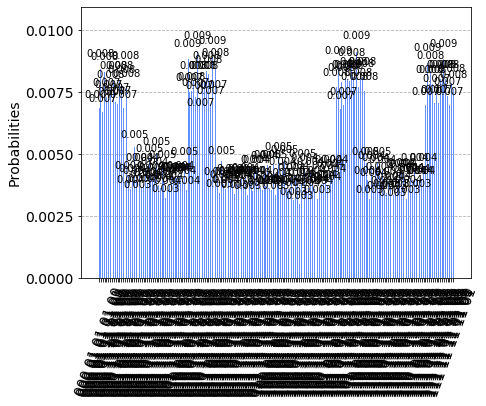

In [33]:
qc=Gcirc3(3,2,Y,X)
backend = BasicAer.get_backend('qasm_simulator')
shot = 20000
results= execute(qc,backend=backend,shots=shot).result()
counts=results.get_counts(qc)
plot_histogram(counts)

In [34]:
print(counts)

{'111 11 01 01 00': 160, '011 11 11 01 00': 71, '001 01 01 11 00': 79, '110 11 01 01 11': 85, '110 01 01 01 01': 79, '100 11 11 11 11': 87, '111 01 01 11 00': 156, '111 01 01 01 00': 139, '101 01 01 11 01': 158, '011 01 01 01 11': 76, '111 11 11 11 01': 152, '001 11 11 01 00': 80, '001 01 01 11 11': 73, '011 01 11 11 10': 79, '001 01 01 01 01': 72, '100 01 11 11 01': 77, '011 11 01 01 01': 79, '000 11 01 01 01': 142, '010 01 11 01 00': 146, '110 01 11 11 10': 62, '011 01 11 11 00': 75, '000 11 01 11 00': 140, '110 11 11 11 11': 89, '100 11 01 11 01': 73, '010 01 11 11 00': 144, '100 11 11 01 10': 83, '100 01 01 01 00': 77, '100 11 11 11 00': 87, '010 11 01 01 01': 159, '101 01 01 01 01': 171, '111 11 01 11 00': 176, '001 11 01 01 10': 91, '011 01 11 01 01': 68, '100 11 11 01 00': 76, '000 11 01 01 00': 159, '001 11 01 11 11': 82, '010 01 01 01 00': 176, '011 01 01 11 00': 72, '100 11 01 11 10': 64, '011 01 11 01 10': 76, '000 11 11 01 01': 137, '011 11 01 01 10': 79, '100 11 11 01 11':

In [37]:
if '101 00 00 00 00' in counts:
    print('010')
else :
    print("nu")

nu


# References !

Captivating lecture:

[1a]MaxCut: https://medium.com/qiskit/the-variational-quantum-eigensolver-43f7718c2747

[1b]MaxCut: https://en.wikipedia.org/wiki/Maximum_cut

[1c]MaxCut: https://quantum-computing.ibm.com/jupyter/tutorial/advanced/aqua/optimization/max_cut_and_tsp.ipynb

[2]FQE: https://doi.org/10.34133/2020/1486935

[3]Duality quantum computer :	arXiv:1507.03200

[4]Gateaux derivative :https://en.wikipedia.org/wiki/Gateaux_derivative
        